### Imports

In [1]:
import matplotlib.pyplot as plt
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim

sys.path.append(os.path.abspath('../'))

from data import get_train_dataloader, get_test_dataloader
from mri import MRI
from nn import NeuralNet, GaussianMapping, PosEncMapping
from utils import get_device


%load_ext autoreload
%autoreload 2

### Data

In [2]:
# Load the MRI data from the file
file_path = '../../../hcp1200/996782/T1w_acpc_dc_restore_brain_downsample_factor_8.nii.gz'
mri = MRI(file_path)

11:33:05 | Reading data from ../../../hcp1200/996782/T1w_acpc_dc_restore_brain_downsample_factor_8.nii.gz


11:33:05 | Displaying relevant brain slices


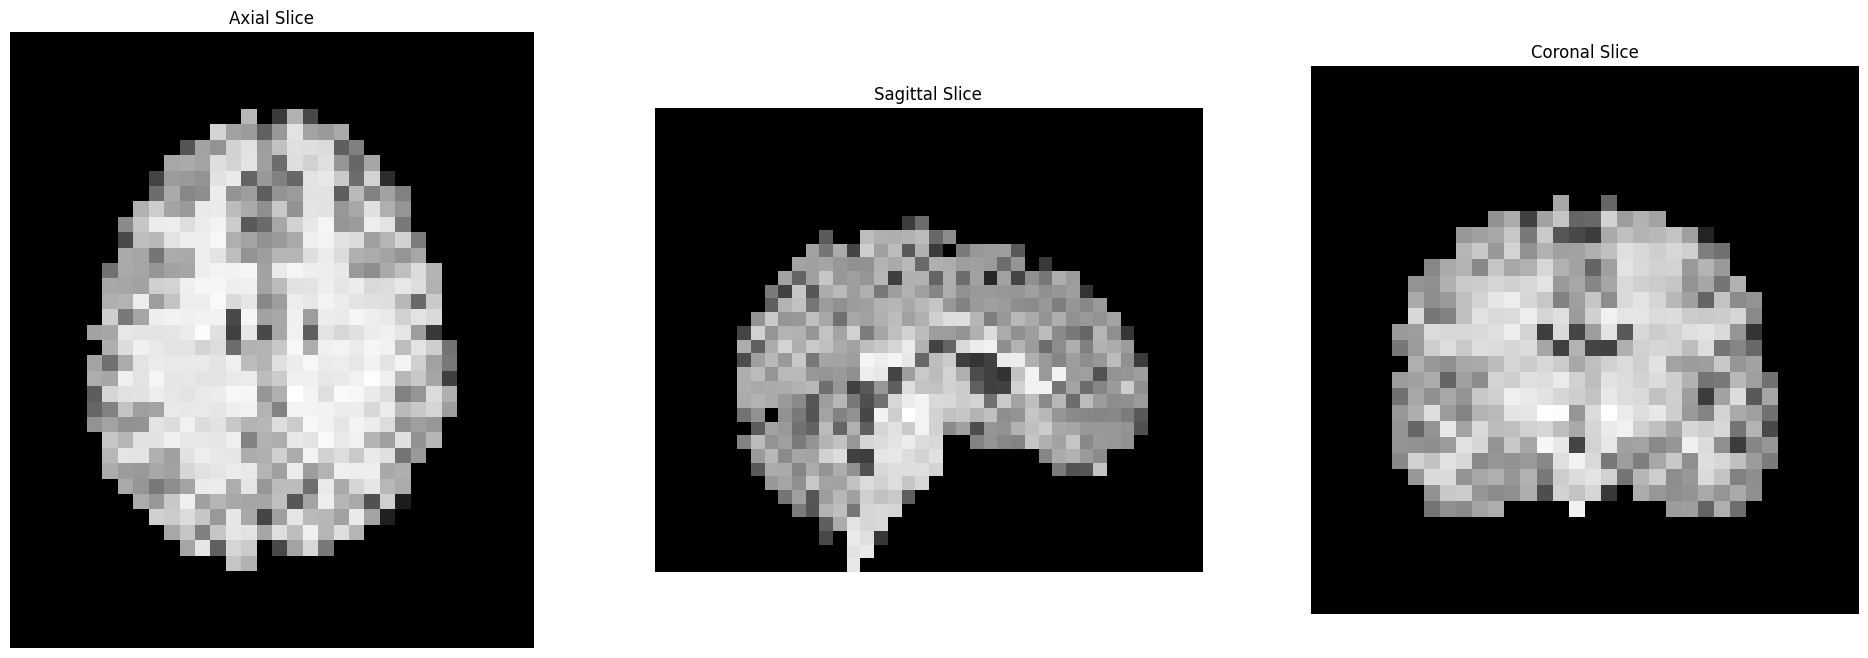

In [3]:
mri.display_relevant_brain_slices()

In [4]:
print(f"Voxel grid size: {mri.data.shape}")
print(f"Total number of points in MRI: {mri.data.flatten().shape[0]}")

Voxel grid size: (34, 40, 34)
Total number of points in MRI: 46240


In [5]:
device = get_device()
dataloader = get_train_dataloader(mri, batch_size=2048, device=device)

------------------------------------------------------------


11:33:06 | Create voxel grid from MRI
11:33:06 | Creating voxel grid: originial voxel grid resolution x1


NVIDIA GeForce RTX 3050 Ti Laptop GPU
Memory Usage:
	Allocated: 0.0 GB
	Reserved:  0.0 GB
------------------------------------------------------------


11:33:09 | Get intensity values from MRI
11:33:10 | Creating the dataloader


### Training

In [65]:
# Initialize network
encoding = 'pos_enc'
if encoding == 'pos_enc':
    input_size = 96 #192 + 96
    fourier_mapping = PosEncMapping(num_frequencies=input_size//6, scale=1000)
else:
    input_size = 256
    fourier_mapping = GaussianMapping(num_frequencies=input_size//2, scale=10, device=device)

net = NeuralNet(input_size=input_size).to(device)

# Optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-4)  # Adjust learning rate as needed

# Loss function
mse_loss = nn.MSELoss()

In [66]:
# Number of epochs - one epoch means the model has seen all the data once
num_epochs = 500  # Adjust as needed

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        # Get the input features and target labels, and put them on the device
        coords, gt_intensity_values = data
        coords, gt_intensity_values = coords.to(device), gt_intensity_values.to(device)
        coords = fourier_mapping.map(coords)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        pred_intensity_values = net(coords)

        # Compute loss
        loss = mse_loss(pred_intensity_values.squeeze(), gt_intensity_values)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss / 100:.3f}')
    running_loss = 0.0

print('Finished Training')

[1] loss: 20425.138
[2] loss: 20112.942
[3] loss: 19989.317
[4] loss: 19849.006
[5] loss: 19842.307
[6] loss: 19774.542
[7] loss: 19741.467
[8] loss: 19641.854
[9] loss: 19661.595
[10] loss: 19562.532
[11] loss: 19455.359
[12] loss: 19458.035
[13] loss: 19411.074
[14] loss: 19387.633
[15] loss: 19297.958
[16] loss: 19269.270
[17] loss: 19215.156
[18] loss: 19202.369
[19] loss: 19090.946
[20] loss: 19064.964
[21] loss: 19022.133
[22] loss: 18903.744
[23] loss: 18916.807
[24] loss: 18835.506
[25] loss: 18775.779
[26] loss: 18732.327
[27] loss: 18703.998
[28] loss: 18614.557
[29] loss: 18567.513
[30] loss: 18480.991
[31] loss: 18483.622
[32] loss: 18397.651
[33] loss: 18333.799
[34] loss: 18303.701
[35] loss: 18220.044
[36] loss: 18182.659
[37] loss: 18149.114
[38] loss: 18069.048
[39] loss: 17991.914
[40] loss: 17974.564
[41] loss: 17930.631
[42] loss: 17829.008
[43] loss: 17788.174
[44] loss: 17723.818
[45] loss: 17609.849
[46] loss: 17558.297
[47] loss: 17461.148
[48] loss: 17462.617
[

In [71]:
upsample_factor = 2
voxel_loader = get_test_dataloader(mri, upsample_factor, 2048, device)

# Set the network to evaluation mode
net.eval()

# Store predictions for each batch
batch_predictions = []

# Disable gradient calculations
with torch.no_grad():
    for batch in voxel_loader:
        # Move batch to device
        coords = batch.to(device)
        coords = fourier_mapping.map(coords)

        # Predict intensity values for the batch
        batch_pred = net(coords)

        # Move predictions to CPU and store
        batch_predictions.append(batch_pred.cpu())

# Concatenate all batch predictions
all_predictions = torch.cat(batch_predictions, dim=0)

# Convert to numpy array
predicted_intensities_np = all_predictions.squeeze().numpy()

# Reshape the array to the desired MRI dimensions
x_dim, y_dim, z_dim = [ax * upsample_factor for ax in mri.data.shape]
predicted_mri = predicted_intensities_np.reshape((x_dim, y_dim, z_dim))

13:55:06 | Creating voxel grid: originial voxel grid resolution x2


(-0.5, 67.5, -0.5, 67.5)

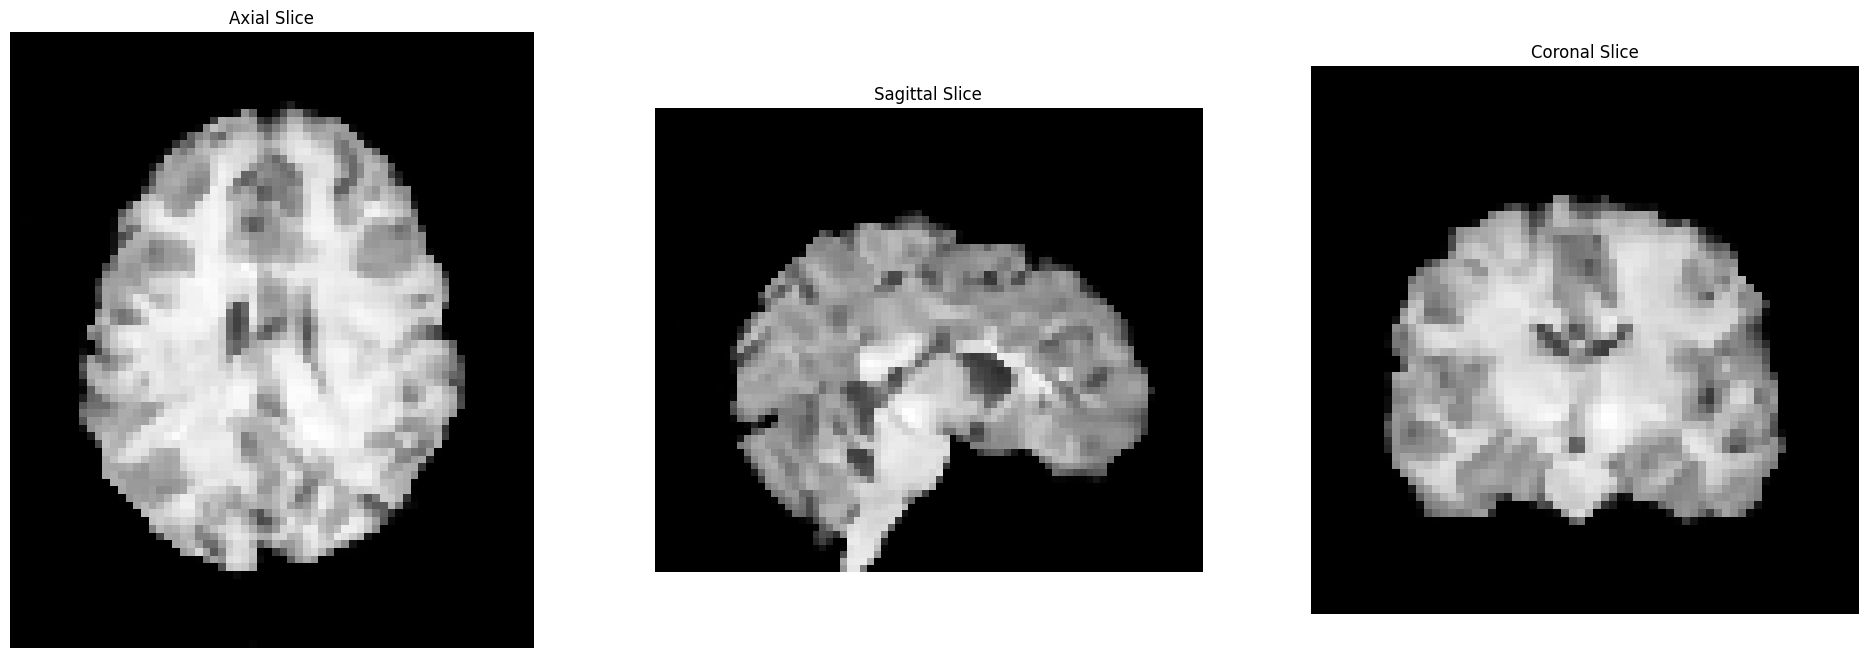

In [72]:
# Select an axial slice - middle of the brain
sagittal_slice = predicted_mri[predicted_mri.shape[0] // 2, :, :]
coronal_slice = predicted_mri[:, predicted_mri.shape[1] // 2, :]
axial_slice = predicted_mri[:, :, predicted_mri.shape[2] // 2]

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Display each slice
axes[0].imshow(axial_slice.T, cmap="gray", origin="lower")
axes[0].set_title("Axial Slice")
axes[0].axis("off")

axes[1].imshow(sagittal_slice.T, cmap="gray", origin="lower")
axes[1].set_title("Sagittal Slice")
axes[1].axis("off")

axes[2].imshow(coronal_slice.T, cmap="gray", origin="lower")
axes[2].set_title("Coronal Slice")
axes[2].axis("off")